In [130]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [131]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [132]:
nels_subset.columns[:100]

Index(['StudentId', 'Degree', 'InSchool12thGrade', 'Sex',
       'MaleGuardianOccupation', 'FemaleGuardianOccupation', 'Race',
       'ParentsHighestLevelEducation', 'HasMoreThan50Books',
       'HasSpecificPlaceForStudy', 'ReceivesNewspaper', 'FamilyHasComputer',
       'ParentsAttendedSchoolMeeting', 'ParentsSpokeWithCounselor',
       'ParentsCheckHomework', 'NoOneHomeWhenReturnFromSchool',
       'FathersWishes', 'MothersWishes', 'HoursWorkingForPayPerWeek',
       'SchoolWorkProblemsEighthGrade', 'TeachingIsGood',
       'TeachersInterestedInStudents', 'StudentDisruptions',
       'AcceleratedEnglish', 'AcceleratedHistory', 'AcceleratedScience',
       'AcceleratedMath', 'TimeSpentMath', 'TimeSpentScience',
       'TimeSpentEnglish', 'TimeSpentHistory', 'GradesMiddleSchoolEnglish',
       'GradesMiddleSchoolMath', 'GradesMiddleSchoolScience',
       'GradesMiddleSchoolHistory', 'PercentMinorityOfSchoolMiddleSchool',
       'PercentFreeLunchOfSchoolMiddleSchool',
       'Socio-econ

In [133]:
# Add 1st/2nd gen immigrant status 
# Native/non native english speaker

target_col = "GradesUndergrad" # Grades
nels_valid_grades = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Make binary decision >= 2.75 GPA
nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
nels_valid_grades = nels_valid_grades.sample(frac=1).reset_index(drop=True)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["Degree", 
"StudentId", 
"HighestPostSecondaryEducationAttained", 
"AttendedFirstChoicePostSecondaryEducation",
"JobSatisfaction", 
"Income",
"TotalEarningsJob1",
"TotalEarningsJob2",
"CoursesAt2To4YearCollege"]

nels_valid_grades = nels_valid_grades[nels_valid_grades.columns.difference(columns_to_withhold)]

X = nels_valid_grades[nels_valid_grades.columns.difference([target_col])]
y = nels_valid_grades[target_col]


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_2437/19572662.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)


In [134]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

nels_valid_grades = resample_up_down(nels_valid_grades, upsample=True, target_col=target_col)
X = nels_valid_grades.loc[:, nels_valid_grades.columns != target_col]
y = nels_valid_grades[target_col]           

1    6640
0    6640
Name: GradesUndergrad, dtype: int64


In [135]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [136]:
rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)


RandomForestClassifier()

In [137]:
predictions = rf.predict(x_test)

In [138]:
print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2039
           1       0.94      0.91      0.93      1945

    accuracy                           0.93      3984
   macro avg       0.93      0.93      0.93      3984
weighted avg       0.93      0.93      0.93      3984



In [139]:
rf_cross = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=5)
scores

array([0.95331325, 0.9563253 , 0.96046687, 0.94879518, 0.95331325])

/Users/lucasrosenblatt/opt/miniconda3/envs/fairness_aif/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


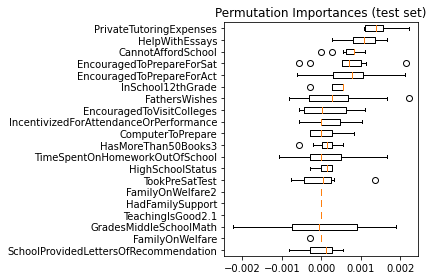

In [ ]:
result = permutation_importance(
    rf, x_test, y_test, n_repeats=10, random_state=0, n_jobs=5, max_samples=1.0, scoring='f1'
)
sorted_idx = result.importances_mean.argsort()[-20:]

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


In [140]:
def return_real_column_name(human, human_list, yucky_list):
    return yucky_list[human_list.index(human)]

human_list = nels_columns_readable.columns.tolist()
yucky_list = nels_columns.columns.tolist()
return_real_column_name('Race', human_list, yucky_list)

'F4RACEM'

In [141]:
toy_columns = ['StudentId',
# .66 Acc RF
'Sex',
'Race',
'CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',

# .86 Acc RF (with base), .96 (second two), .58 (alone)
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',
'HelpWithEssays',
'ParentsCheckHomework',

# .92 Acc FR (with base), .82 (alone)
'HighSchoolHelpedWithSchoolApplication',
'HelpedWithFinancialAidApp',
'ParentsHighestLevelEducation',
'Socio-economicStatusQuartile',
'PrivateSchoolExpenses',
'PrivateTutoringExpenses',
'Tutored',
'FathersWishes',
'MothersWishes',

'GradesUndergrad']

In [147]:
# Only valid grades
toy_dataframe = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Only white/black nonhispanic
toy_dataframe = toy_dataframe[(3 <= toy_dataframe['Race']) & (toy_dataframe['Race'] <= 4)]

# Shuffle randomly before training models
toy_dataframe = toy_dataframe.sample(frac=1).reset_index(drop=True)

toy_dataframe = toy_dataframe[toy_columns]

# Make binary decision >= 2.75 GPA
toy_dataframe[target_col] = np.where(toy_dataframe[target_col] <= 3, 1, 0)
make_string = False

if make_string:
    # Make binary decision >= 2.75 GPA
    toy_dataframe["Race"] = np.where(toy_dataframe["Race"] == 3, "Black", "White")
    toy_dataframe["Sex"] = np.where(toy_dataframe["Sex"] == 1, "Male", "Female")

toy_dataframe = resample_up_down(toy_dataframe, upsample=True, target_col=target_col)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["StudentId"]

X = toy_dataframe[toy_dataframe.columns.difference([target_col]+columns_to_withhold)]
y = toy_dataframe[target_col]

1    5154
0    5154
Name: GradesUndergrad, dtype: int64


In [148]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1048
           1       0.97      0.89      0.93      1014

    accuracy                           0.93      2062
   macro avg       0.94      0.93      0.93      2062
weighted avg       0.94      0.93      0.93      2062



In [149]:
tiny_test = toy_dataframe[:500]
student = int(tiny_test.iloc[0]['StudentId'])

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_2437/1233870880.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = [10, 8])


<Figure size 720x576 with 0 Axes>

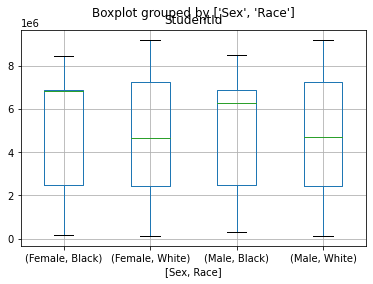

<Figure size 720x576 with 0 Axes>

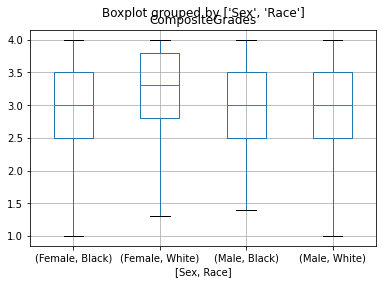

<Figure size 720x576 with 0 Axes>

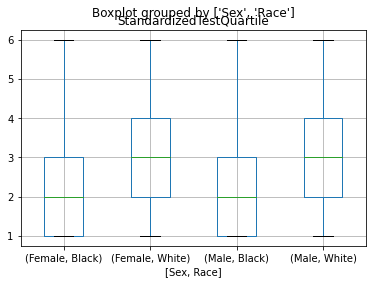

<Figure size 720x576 with 0 Axes>

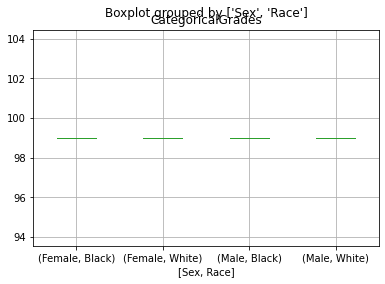

<Figure size 720x576 with 0 Axes>

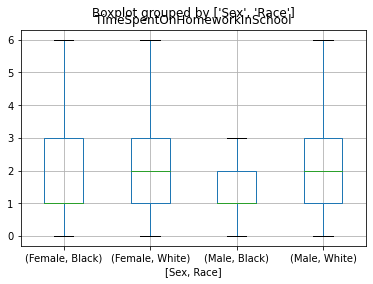

<Figure size 720x576 with 0 Axes>

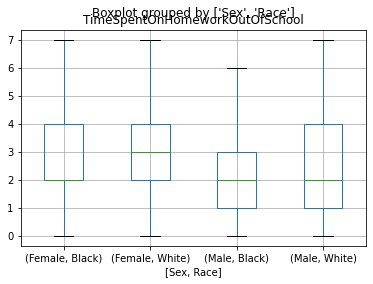

<Figure size 720x576 with 0 Axes>

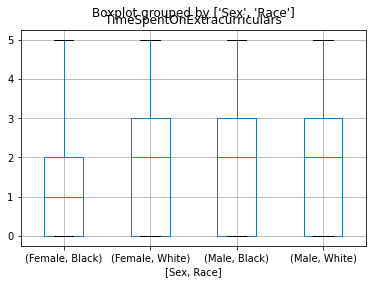

<Figure size 720x576 with 0 Axes>

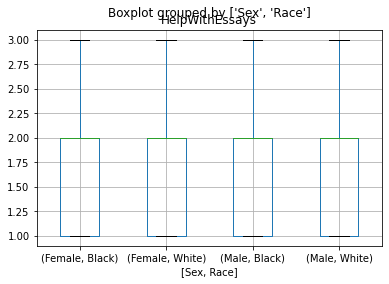

<Figure size 720x576 with 0 Axes>

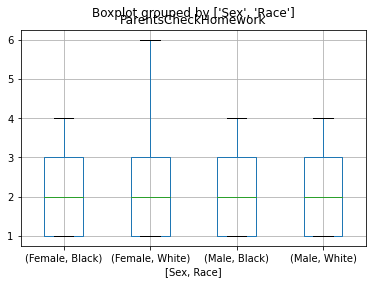

<Figure size 720x576 with 0 Axes>

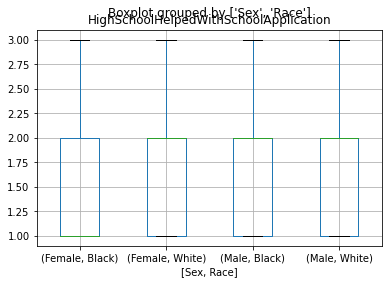

<Figure size 720x576 with 0 Axes>

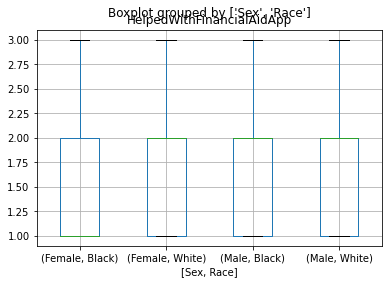

<Figure size 720x576 with 0 Axes>

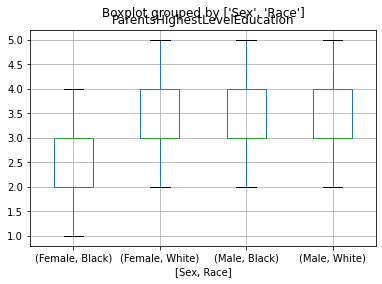

<Figure size 720x576 with 0 Axes>

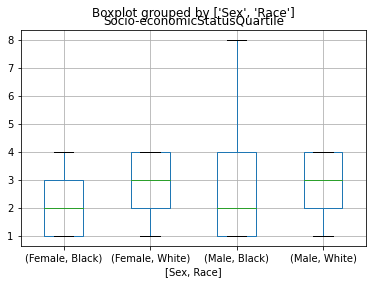

<Figure size 720x576 with 0 Axes>

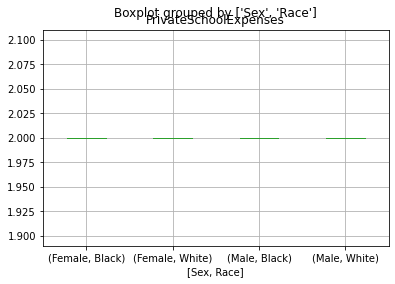

<Figure size 720x576 with 0 Axes>

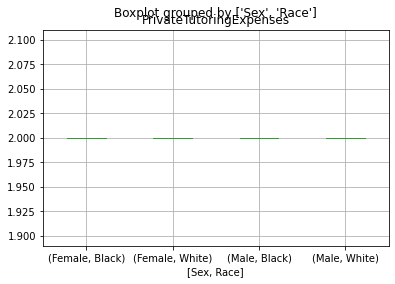

<Figure size 720x576 with 0 Axes>

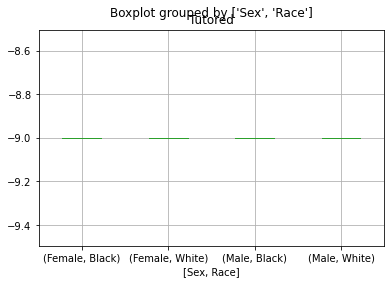

<Figure size 720x576 with 0 Axes>

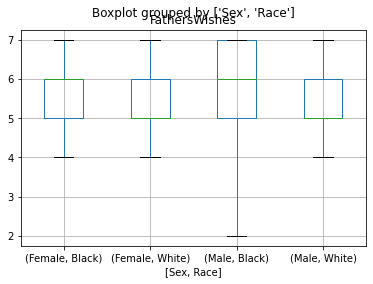

<Figure size 720x576 with 0 Axes>

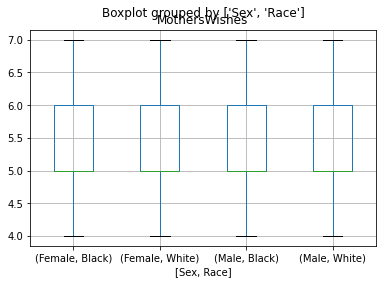

<Figure size 720x576 with 0 Axes>

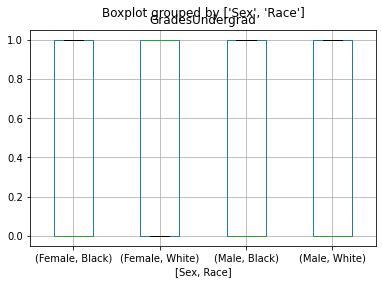

In [116]:
import matplotlib.pyplot as plt

for column in tiny_test:
    if column != 'Sex' and column != 'Race':
        plt.figure(figsize = [10, 8])
        tiny_test.boxplot([column], by=['Sex', 'Race'], showfliers=False)

In [150]:
from swap_auditor import NaiveSwapAuditor

new = NaiveSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
new.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'])

In [151]:
ind = student
s, marg = new._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)


For individual: 7759088
Stability: 1.0
Marginals:

Tutored: 1.0
Socio-economicStatusQuartile: 1.0
FathersWishes: 1.0
TutoredSocio-economicStatusQuartile: 1.0
TutoredFathersWishes: 1.0
Socio-economicStatusQuartileFathersWishes: 1.0
TutoredSocio-economicStatusQuartileFathersWishes: 1.0



In [152]:
new._calculate_subgroup_stability()
print(new.subgroup_stability)
sg = '14'
s, marg = new._retrieve_stability_subgroup(sg)
print("\nFor subgroup: " + str(sg))
print('Stability: ' + str(s))
print(marg)

{'24': (432795, 437325, {'Tutored': (62475, 62475), 'Socio-economicStatusQuartile': (61885, 62475), 'FathersWishes': (61801, 62475), 'TutoredSocio-economicStatusQuartile': (61942, 62475), 'TutoredFathersWishes': (61873, 62475), 'Socio-economicStatusQuartileFathersWishes': (61353, 62475), 'TutoredSocio-economicStatusQuartileFathersWishes': (61466, 62475)}), '23': (119267, 119917, {'Tutored': (17131, 17131), 'Socio-economicStatusQuartile': (16992, 17131), 'FathersWishes': (17066, 17131), 'TutoredSocio-economicStatusQuartile': (16984, 17131), 'TutoredFathersWishes': (17063, 17131), 'Socio-economicStatusQuartileFathersWishes': (17021, 17131), 'TutoredSocio-economicStatusQuartileFathersWishes': (17010, 17131)}), '14': (403064, 417088, {'Tutored': (59398, 59584), 'Socio-economicStatusQuartile': (57774, 59584), 'FathersWishes': (57706, 59584), 'TutoredSocio-economicStatusQuartile': (57819, 59584), 'TutoredFathersWishes': (57776, 59584), 'Socio-economicStatusQuartileFathersWishes': (56256, 595

In [153]:
from swap_auditor import RandomizedSamplingSwapAuditor
randomized = RandomizedSamplingSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
randomized.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'], delta=0.1, epsilon=0.5)
# print(randomized.individual_stability)

Iterations: 19


In [154]:
ind = student
s, marg = randomized._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)


For individual: 7759088
Stability: 1.0
Marginals:

Tutored: 1.0
Socio-economicStatusQuartile: 1.0
FathersWishes: 1.0
TutoredSocio-economicStatusQuartile: 1.0
TutoredFathersWishes: 1.0
Socio-economicStatusQuartileFathersWishes: 1.0
TutoredSocio-economicStatusQuartileFathersWishes: 1.0



In [155]:
randomized._calculate_subgroup_stability()
print(randomized.subgroup_stability)
sg = '14'
s, marg = randomized._retrieve_stability_subgroup(sg)
print("\nFor subgroup: " + str(sg))
print('Stability: ' + str(s))
print(marg)

{'24': (33569, 33915, {'Tutored': (4845, 4845), 'Socio-economicStatusQuartile': (4804, 4845), 'FathersWishes': (4797, 4845), 'TutoredSocio-economicStatusQuartile': (4804, 4845), 'TutoredFathersWishes': (4794, 4845), 'Socio-economicStatusQuartileFathersWishes': (4765, 4845), 'TutoredSocio-economicStatusQuartileFathersWishes': (4760, 4845)}), '23': (4884, 4921, {'Tutored': (703, 703), 'Socio-economicStatusQuartile': (695, 703), 'FathersWishes': (700, 703), 'TutoredSocio-economicStatusQuartile': (693, 703), 'TutoredFathersWishes': (702, 703), 'Socio-economicStatusQuartileFathersWishes': (693, 703), 'TutoredSocio-economicStatusQuartileFathersWishes': (698, 703)}), '14': (25189, 26068, {'Tutored': (3708, 3724), 'Socio-economicStatusQuartile': (3608, 3724), 'FathersWishes': (3604, 3724), 'TutoredSocio-economicStatusQuartile': (3613, 3724), 'TutoredFathersWishes': (3615, 3724), 'Socio-economicStatusQuartileFathersWishes': (3514, 3724), 'TutoredSocio-economicStatusQuartileFathersWishes': (3527

In [156]:
from swap_auditor import RandomizedGroupSwapAuditor
randomized_group = RandomizedGroupSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
randomized_group.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'], delta=0.1, epsilon=0.5, t=1) # t=1
# print(randomized_group.individual_stability)

ind = student
s, marg = randomized_group._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)

Iterations: 1

For individual: 7759088
Stability: 1.0
Marginals:

Tutored: 1.0
Socio-economicStatusQuartile: 1.0
FathersWishes: 1.0
TutoredSocio-economicStatusQuartile: 1.0
TutoredFathersWishes: 1.0
Socio-economicStatusQuartileFathersWishes: 1.0
TutoredSocio-economicStatusQuartileFathersWishes: 1.0



In [157]:
randomized_group._calculate_subgroup_stability()
print(randomized_group.subgroup_stability)
sg = '14'
s, marg = randomized_group._retrieve_stability_subgroup(sg)
print("\nFor subgroup: " + str(sg))
print('Stability: ' + str(s))
print(marg)

{'24': (3400, 3430, {'Tutored': (490, 490), 'Socio-economicStatusQuartile': (487, 490), 'FathersWishes': (486, 490), 'TutoredSocio-economicStatusQuartile': (485, 490), 'TutoredFathersWishes': (486, 490), 'Socio-economicStatusQuartileFathersWishes': (484, 490), 'TutoredSocio-economicStatusQuartileFathersWishes': (482, 490)}), '23': (1196, 1204, {'Tutored': (172, 172), 'Socio-economicStatusQuartile': (172, 172), 'FathersWishes': (170, 172), 'TutoredSocio-economicStatusQuartile': (171, 172), 'TutoredFathersWishes': (170, 172), 'Socio-economicStatusQuartileFathersWishes': (170, 172), 'TutoredSocio-economicStatusQuartileFathersWishes': (171, 172)}), '14': (3321, 3430, {'Tutored': (489, 490), 'Socio-economicStatusQuartile': (479, 490), 'FathersWishes': (474, 490), 'TutoredSocio-economicStatusQuartile': (476, 490), 'TutoredFathersWishes': (477, 490), 'Socio-economicStatusQuartileFathersWishes': (460, 490), 'TutoredSocio-economicStatusQuartileFathersWishes': (466, 490)}), '13': (451, 504, {'Tu